In [1]:
import roboticstoolbox as rtb
import numpy as np
import matplotlib.pyplot as plt
from spatialmath import SE3
from spatialmath.base import *

กำหนด DH parameters ที่ได้จากการสร้าง

DHRobot: my_robot, 4 joints (RRRR), dynamics, modified DH parameters
┌──────┬────────┬───────────┬──────┐
│ aⱼ₋₁ │  ⍺ⱼ₋₁  │    θⱼ     │  dⱼ  │
├──────┼────────┼───────────┼──────┤
│  0.0 │   0.0° │        q1 │  200 │
│  0.0 │ -90.0° │  q2 - 90° │ -120 │
│  250 │   0.0° │  q3 + 90° │  100 │
│  0.0 │  90.0° │        q4 │  280 │
└──────┴────────┴───────────┴──────┘

┌──┬──┐
└──┴──┘



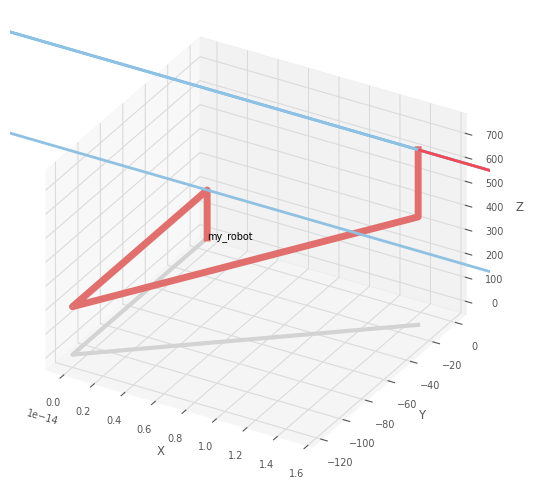

PyPlot3D backend, t = 0.05, scene:
  robot: Text(0.0, 0.0, 'my_robot')

<Figure size 640x480 with 0 Axes>

In [4]:
robot = rtb.DHRobot([
    rtb.RevoluteMDH(d=200),
    rtb.RevoluteMDH(d=-120, alpha=-np.pi/2,offset=-np.pi/2),
    rtb.RevoluteMDH(d=100, a=250, alpha=0,offset=np.pi/2),
    rtb.RevoluteMDH(d=280,alpha=np.pi/2)
], name='my_robot')

print(robot)

q = [0, 0, 0, 0] 

robot.plot(q)

กำหนด Limit ข้อต่อแต่ละข้อ

In [10]:
q1_vals = np.linspace(-np.pi,np.pi,100)  # ข้อต่อ 1
q2_vals = np.linspace(-np.pi/2, np.pi/2,100)  # ข้อต่อ 2
q3_vals = np.linspace(-np.pi/2, np.pi/2,100)  # ข้อต่อ 3
q4_vals = 0

workspace_points = []

for q1 in q1_vals:
    for q2 in q2_vals:
        for q3 in q3_vals:
            q4 = 0
            q = [q1,q2,q3,q4]
            T_0_4 = robot.fkine(q)
            pos = T_0_4.t
            workspace_points.append(pos)
            
workspace_points = np.array(workspace_points)



SAVE TO CSV FILE

In [12]:
csv_file_path ='workspace_points.csv'
np.savetxt(csv_file_path, workspace_points, delimiter=',')

ทำการ Plot รูปและตำแหน่ง Max Min

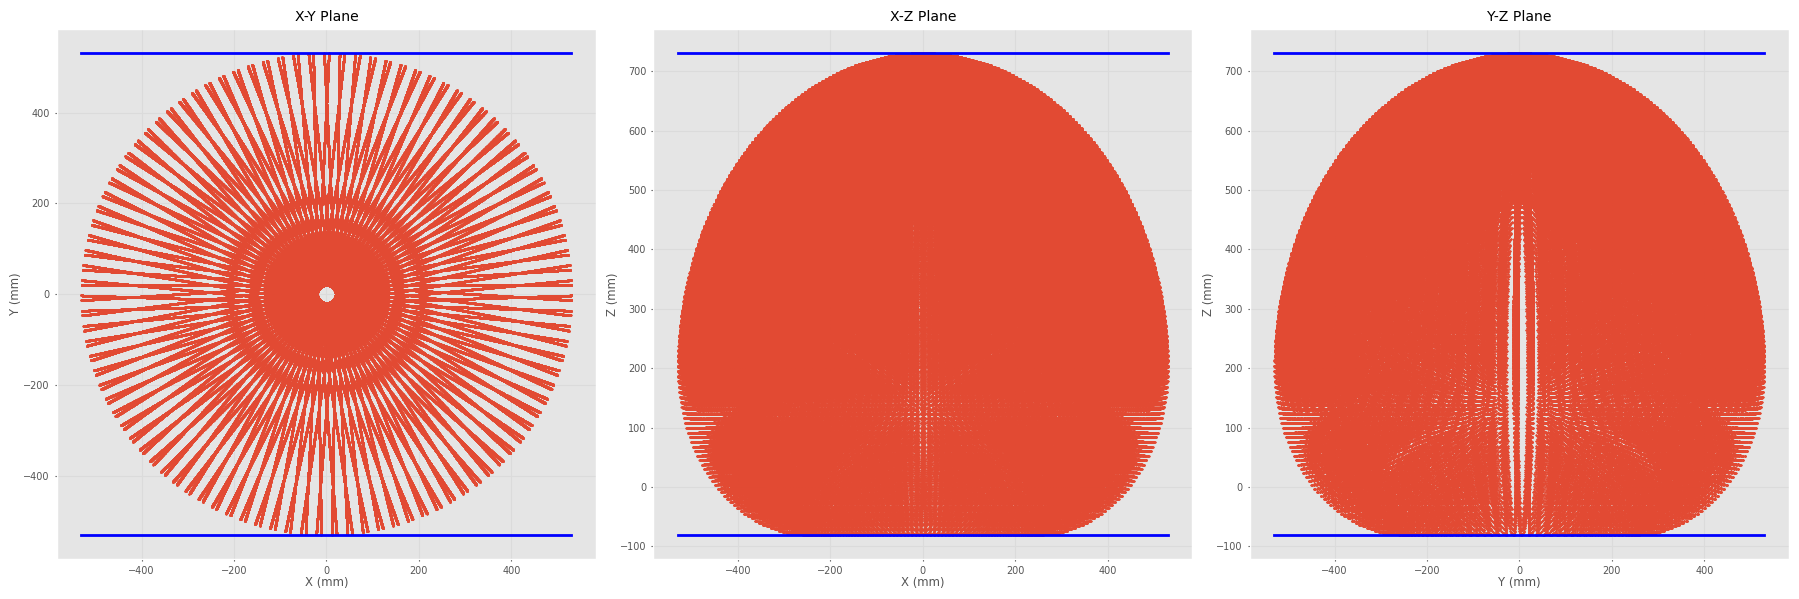

Min X : -530.3324996257212, Max x : 530.3324996257213,Min y : -530.2153671288108,Max y : 530.3161237519366, Min Z : -80.0,Max Z : 729.9685319184688


In [15]:
min_x, max_x = np.min(workspace_points[:, 0]), np.max(workspace_points[:, 0])
min_y, max_y = np.min(workspace_points[:, 1]), np.max(workspace_points[:, 1])
min_z, max_z = np.min(workspace_points[:, 2]), np.max(workspace_points[:, 2])

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# X-Y Plane
axs[0].scatter(workspace_points[:, 0], workspace_points[:, 1], s=1)
axs[0].plot([min_x, max_x], [max_y, max_y], color='blue', linewidth=2) 
axs[0].plot([min_x, max_x], [min_y, min_y], color='blue', linewidth=2) 
axs[0].set_xlabel('X (mm)')
axs[0].set_ylabel('Y (mm)')
axs[0].set_title('X-Y Plane')

# X-Z Plane
axs[1].scatter(workspace_points[:, 0], workspace_points[:, 2], s=1)
axs[1].plot([min_x, max_x], [max_z, max_z], color='blue', linewidth=2) 
axs[1].plot([min_x, max_x], [min_z, min_z], color='blue', linewidth=2) 
axs[1].set_xlabel('X (mm)')
axs[1].set_ylabel('Z (mm)')
axs[1].set_title('X-Z Plane')

# Y-Z Plane
axs[2].scatter(workspace_points[:, 1], workspace_points[:, 2], s=1)
axs[2].plot([min_y, max_y], [max_z, max_z], color='blue', linewidth=2) 
axs[2].plot([min_y, max_y], [min_z, min_z], color='blue', linewidth=2) 
axs[2].set_xlabel('Y (mm)')
axs[2].set_ylabel('Z (mm)')
axs[2].set_title('Y-Z Plane')

plt.tight_layout()
plt.show()

print(f'Min X : {min_x}, Max x : {max_x},Min y : {min_y},Max y : {max_y}, Min Z : {min_z},Max Z : {max_z}')

INIKE

In [5]:
# Define desired end-effector position and orientation
x = -158
y = 391
z = -30
# Convert roll, pitch, yaw angles from degrees to radians
# roll = np.deg2rad(30)
# pitch = np.deg2rad(45)
# yaw = np.deg2rad(60)

# Create the desired transformation matrix using SE3
goal_pose = SE3(x,y,z)
solutions = []
best_solution = None
min_norm = float('inf') 

for i in range(10):
    initial_joint_angles = np.random.uniform(low=-np.pi, high=np.pi, size=4)
    
    solution = robot.ikine_LM(goal_pose, q0=initial_joint_angles, mask=[1, 1, 1, 0, 0, 0])

    if solution.success:
        is_unique = True
        for s in solutions:
            if np.allclose(solution.q, s, atol=1e-2):  
                is_unique = False
                break
                    
        if is_unique:
            solutions.append(solution.q.tolist())
            norm = np.linalg.norm(np.array(solution.q) - np.array(q))

            if norm < min_norm:
                min_norm = norm
                best_solution = solution.q.tolist()

print(best_solution)
print("============")
print(solutions)

[-1.2342102821870409, -1.6051339549699708, -0.8777380869314122, -0.5455087831731826]
[[2.0022683617388513, 2.5359991251340377, -0.8777380869314135, 2.110323534657521], [-1.2342102821870407, -2.535999125134039, 0.8777380869314158, 0.8668125903032022], [2.0022683617388513, 2.5359991251340377, -0.8777380869314131, -0.2444121252445366], [-1.2342102821870407, -1.6051339549699704, -0.877738086931414, 1.96188518783197], [-1.2342102821870409, -1.6051339549699708, -0.8777380869314131, -1.5127230768534596], [2.0022683617388513, 2.5359991251340386, -0.877738086931414, -2.621365869778892], [-1.2342102821870409, -1.6051339549699708, -0.8777380869314122, -0.5455087831731826], [-1.2342102821869994, -1.6051339549611103, -0.8777380869484404, 0.596689406860329], [-1.2342102821870407, -1.6051339549699708, -0.8777380869314135, 1.7580642155084236], [2.0022683617388513, 2.5359991251340377, -0.8777380869314131, 1.143841139445211]]
